# Audrey's Final Project: Trade-Offs & Selection

Here, I plan to build upon the pandemic/vaccine model that we've been working with for the past few weeks. Starting with the initial virus that we built together, I want to change two parameters: probability of infection and infection period. The two will contradict each other in that a high value for one parameter will be accompanied by a lower value for the other, and vice versa. Graphing the viral count for each combination of values will provide insights into which combination of trade-offs is the most virulent.

In [1]:
#importing all the necessary packages to run the model
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
#previously defined elements of the "graph" class. 
class Graph():
    def __init__(self):
        self.gdict = {}
        self.val = {}
        
    def add_node(self, node, val= None):
        if node not in self.gdict:
            self.gdict[node] = []
        self.val[node] = val
        
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
       
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
    
    def delete_node(self, doomed_node):
        if doomed_node not in self.gdict:
            raise KeyError(f"cannot delete {doomed_node}; it doesn't exist!")
            for other_node in self.gdict[doomed_node]:
                self.gdict[other_node].remove(doomed_node)
            del self.gdict[doomed_node]
            del self.values[doomed_node]
    
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return 
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
        
    def get_nodes(self):
        """list of nodes"""
        return list(self.gdict.keys()) 
    
    def get_edges(self):
        """list of edges"""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
    
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1,0,0)
        BLUE = (0,0.2,0.6)
        GREEN = (0, 0.8, 0.5)
        YELLOW = (0.5, 0.5, 0.5)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.val[nodes[i]] is not None:
                if self.val[nodes[i]][0] == 'healthy':
                    colors.append(BLUE)
                elif self.val[nodes[i]][0] == 'infected':
                    colors.append(RED)
                elif self.val[nodes[i]][0] == 'vaccinated':
                    colors.append(YELLOW)
                else:
                    colors.append(GREEN)
            else:
                colors.append(BLUE)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)

In [3]:
def degrees(g):
    """plots how many nodes have a given number of degrees (histogram)"""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    
    plt.plot(hist,'.-');
    plt.xlabel('degrees')
    plt.ylabel('frequency')
    
    return hist

In [4]:
def barabasi(n_nodes = 9):
    """the network we use–follows the formula n edges = 2 * n nodes"""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    
    for i in range(n_nodes):
        if i == 0:
            g.add_node(0)
        elif i == 1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else:
            connections = np.random.choice(nodes[:i], size = 2, replace = False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i, "nodes:", nodes, "degrees:", degrees)
    return g

#g = barabasi(20)
#plt.figure(figsize=(12,4))
#plt.subplot(121)
#g.plot()
#plt.subplot(122)
#degrees(g)

/Users/audreyrussell/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


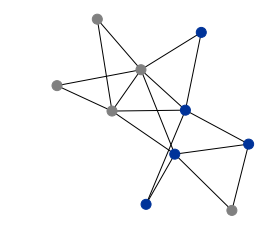

In [5]:
def vaccinate(g, vax_rate = 0, preference = 1):
    '''distribute vaccination status. preference == 1 means no assortativity'''
    nodes = g.get_nodes()
    n_to_vaccinate = int(len(nodes) * vax_rate)
    #np.random.choic
    prob = np.ones(len(nodes)) / len(nodes)
    for node in nodes:
        prob[node] = 1
    for i in range(n_to_vaccinate):
        p = []
        for node in nodes:
            p.append(prob[node])
        target_node = np.random.choice(nodes, p = p/np.sum(p))
        g.val[target_node] = ['vaccinated', 0]
        for friend in g.gdict[node]:
            prob[friend] *= preference
        nodes.remove(target_node)
    for node in nodes:
        g.val[node] = ['healthy', 0]
g = barabasi(10)
vaccinate(g, vax_rate = 0.5)
plt.figure(figsize = (3,3))
g.plot()
#print(measure_assortativity(g))

In [6]:
print(g.val)

{0: ['vaccinated', 0], 1: ['healthy', 0], 2: ['healthy', 0], 3: ['vaccinated', 0], 4: ['vaccinated', 0], 5: ['healthy', 0], 6: ['healthy', 0], 7: ['vaccinated', 0], 8: ['healthy', 0], 9: ['vaccinated', 0]}


In [7]:
def measure_assortativity(g):
    """calculates the probability that connected nodes share the same assortativity value"""
    count = 0
    edges = g.get_edges()
    for edge in edges:
        if g.val[edge[0]][0]==g.val[edge[1]][0]:
            #print(g.values[edge[0]][0],g.values[edge[1]][0])
            count += 1
    return count/len(edges)

measure_assortativity(g)

0.5882352941176471

In [8]:
def pandemic(g, prob, nsteps, infect_period, reinitialize=True):
    """runs the pandemic. """
    nodes = g.get_nodes()
    if reinitialize:
        susceptible = []
        for node in nodes:
            if g.val[node][0]=='healthy':
                susceptible.append(node)
        patient_zero = np.random.choice(susceptible)
        g.val[patient_zero] = ['infected', 0] 

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        is_active = False
        for node in nodes:
            if g.val[node][0] == 'infected':         
                is_active = True
                if g.val[node][1] == infect_period:
                    g.val[node][0] = 'immune'
                else:
                    g.val[node][1] += 1                  
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.val[neighbor][0]=='healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.val[node] = ['infected', 0]
        history[t] = len(newly_infected)
    return history

#g = barabasi(20)
#plt.figure(figsize=(12,6))
#for i in range(8):
#    if i==0:
#        vaccinate(g, 0.5, 1)
#        pandemic(g, prob=0.5, nsteps=1, infect_period=1)
#    else:
#        pandemic(g, prob=0.5, nsteps=1, infect_period=1, reinitialize=False)
#    plt.subplot(2,4,i+1)
#    g.plot()
#   plt.title(i)


Here is the experiment, where I will run several generations of the pandemic. I will go through each value of infectiousness and infection period, and graph the infection rates of all of them. 

In [47]:

#constants:
N_STEPS = 10
N_NODES = 100
VAX_RATE = 0.5
N_PARAM_STEPS = 10 #goes through x many values
N_TRIALS = 10 #for each combination of parameters

#counters:
history = np.zeros(shape = (N_STEPS, N_TRIALS*N_PARAM_STEPS)) #2 dimensional–use number of people affected
total_infected = np.zeros(shape = (N_TRIALS, N_PARAM_STEPS))

#variable parameters
prob = np.zeros(N_STEPS)
infect_period = np.zeros(N_STEPS)

#print(g.val)

for iparam in range(N_PARAM_STEPS):
    prob[iparam] = np.random.uniform(0.1, 0.9)
    infect_period[iparam] =  (1 - prob[iparam])
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        vaccinate(g, vax_rate = 0.5)
        history[:, itrial+iparam*N_TRIALS] = pandemic(g, prob = prob[iparam], 
                                                     nsteps=N_STEPS, infect_period = infect_period[iparam])
        count_infected = 0
        for node, val in g.val.items():
            if val[0] == 'immune' or val[0] == 'infected':
                count_infected += 1
        total_infected[itrial, iparam] = count_infected
        


In [70]:
print(total_infected)
print(prob)

[[44. 35. 45.  3. 46. 44.  7. 41.  1.  7.]
 [38. 41. 40.  1.  1. 40. 32. 32.  1.  8.]
 [44.  1. 40. 37. 44. 32.  2.  1. 22.  7.]
 [35. 42. 40. 39. 43. 34. 43. 41. 29.  1.]
 [ 1. 38. 45.  1. 42. 46. 26. 46. 44.  1.]
 [46.  1. 41. 45.  1. 17.  9.  1. 36.  7.]
 [ 1. 48. 37. 38. 29.  1.  1. 38. 42.  2.]
 [ 2. 34. 38. 40. 47. 40.  2. 49. 17.  2.]
 [37. 40.  1. 37. 38. 30. 20. 46. 15.  8.]
 [ 8.  2. 45. 20. 42. 30. 43. 43. 45.  7.]]
[0.54154879 0.89152927 0.59648969 0.61607468 0.87839085 0.68783319
 0.26931361 0.73786081 0.54888846 0.11222156]


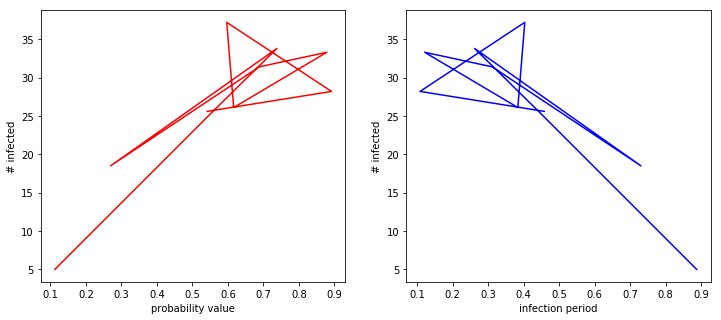

In [69]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(prob, np.average(total_infected, axis = 0), '-', color='red')
plt.xlabel("probability value");
plt.ylabel("# infected");


plt.subplot(122)
plt.plot(infect_period, np.average(total_infected, axis = 0), '-', color='blue')
plt.xlabel("infection period");
plt.ylabel("# infected");